In [1]:
pip install opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

In [2]:
#  Set memory growth for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
data_dir = "E:\Mangrove project\EfficientNet\Data"
class_names = os.listdir(data_dir)
class_names.sort()
print(f'Class names: {class_names}')
image_exts = ['jpeg', 'png', 'jpg', 'bmp']
class_count = len(class_names)

Class names: ['Acrostichum aureum', 'Avicennia rumphiana', 'Lumnitzera racemosa', 'Nypa fruticans', 'Rhizophora mucronata']


In [4]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [5]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(224, 224), batch_size=32, label_mode='categorical')

Found 4991 files belonging to 5 classes.


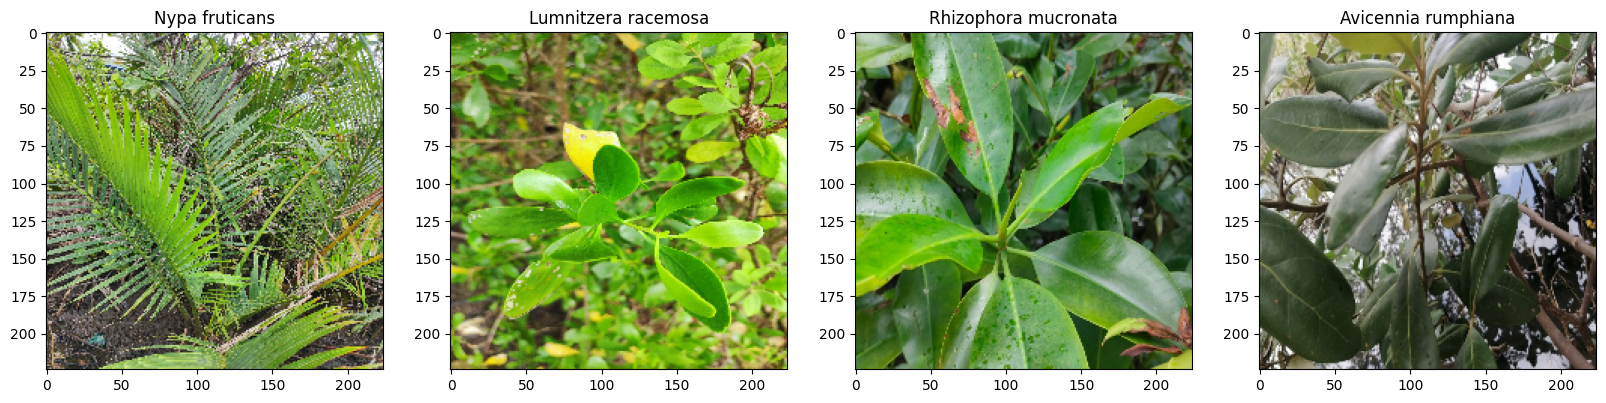

In [6]:
# Normalize the data
data = data.map(lambda x, y: (x / 255, y))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(class_names[np.argmax(batch[1][idx])])
plt.show()

In [7]:
batch = data.as_numpy_iterator().next()
batch[0].shape

(32, 224, 224, 3)

In [8]:
# Split the data
train_size = int(len(data) * .7)
val_size = int(len(data) * .2)
test_size = int(len(data) * .1) + 1
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [9]:
def make_model(img_size, lr, mod_num=3):
    img_shape = (img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model = tf.keras.applications.EfficientNetB5(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNet B5 model'
    else:
        base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNet B7 model'

    base_model.trainable = True
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
    x = Dropout(rate=.4, seed=123)(x)
    output = Dense(class_count, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    msg = msg + f' with initial learning rate set to {lr}'
    print(msg)
    return model

In [10]:
lr = .001
img_size = (224, 224)
model = make_model(img_size, lr)  # using B3 model by default

Created EfficientNet B3 model with initial learning rate set to 0.001


In [11]:
logdir = "E:\Mangrove project\EfficientNet\logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/10
109/109 [==============================] - 798s 7s/step - loss: 6.7837 - accuracy: 0.9080 - val_loss: 8.2303 - val_accuracy: 0.2056
Epoch 2/10
109/109 [==============================] - 682s 6s/step - loss: 4.3791 - accuracy: 0.9837 - val_loss: 7.8896 - val_accuracy: 0.2268
Epoch 3/10
109/109 [==============================] - 672s 6s/step - loss: 2.9906 - accuracy: 0.9900 - val_loss: 4.7913 - val_accuracy: 0.3861
Epoch 4/10
109/109 [==============================] - 692s 6s/step - loss: 2.0667 - accuracy: 0.9948 - val_loss: 3.7165 - val_accuracy: 0.4002
Epoch 5/10
109/109 [==============================] - 705s 6s/step - loss: 1.4386 - accuracy: 0.9940 - val_loss: 2.4373 - val_accuracy: 0.5141
Epoch 6/10
109/109 [==============================] - 692s 6s/step - loss: 1.0026 - accuracy: 0.9966 - val_loss: 0.9998 - val_accuracy: 0.9395
Epoch 7/10
109/109 [==============================] - 718s 7s/step - loss: 0.7098 - accuracy: 0.9977 - val_loss: 0.7153 - val_accuracy: 0.9466

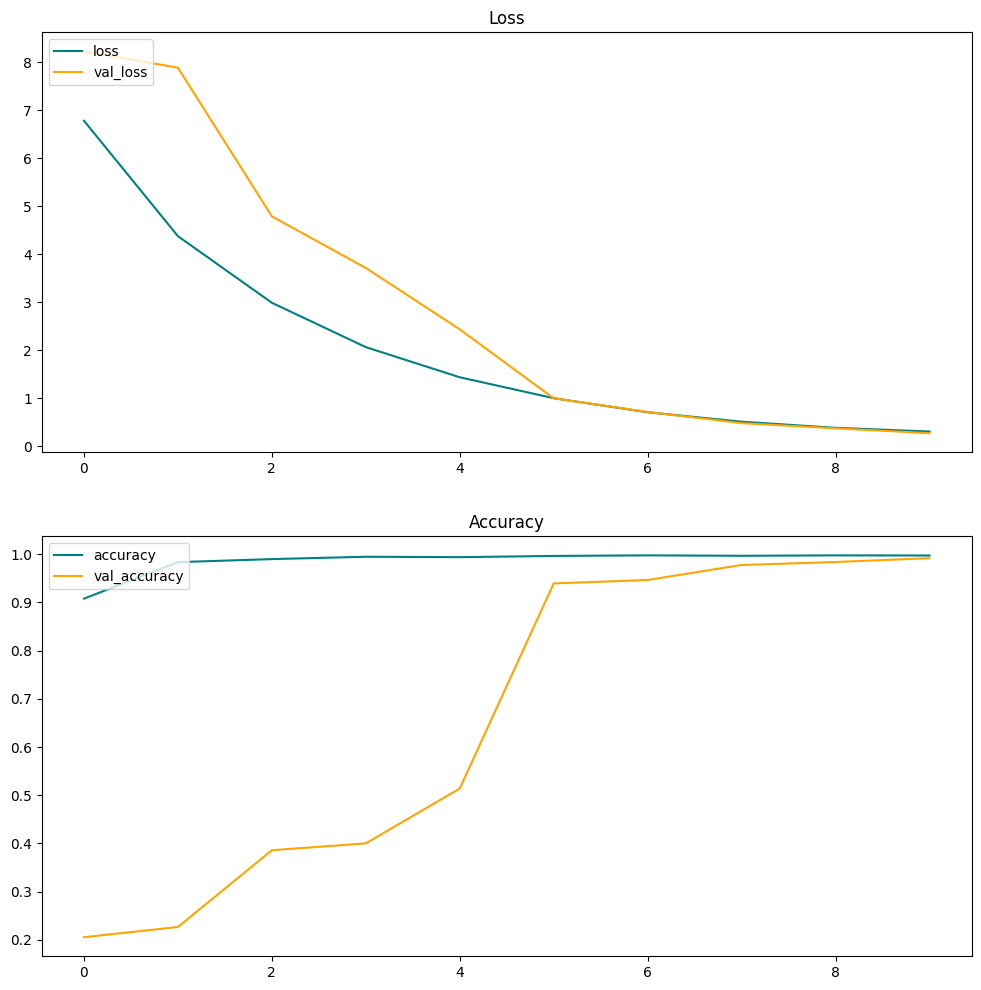

In [12]:
# Plot the training history
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
ax[0].set_title('Loss')
ax[0].legend(loc="upper left")

ax[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend(loc="upper left")

plt.show()

In [13]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [14]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [15]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

1/1 [==============================] - 4s 4s/step
Precision: 0.9960784316062927, Recall: 0.9941291809082031, Accuracy: 0.9941291809082031


In [16]:
try:
    weights_path = "E:\\Mangrove project\\models\\efficientnet_imageclassifier_weights.h5"
    model.save_weights(weights_path)
    print(f"Model weights saved successfully at {weights_path}")

    # Recreate the model structure and load the weights
    model = make_model(img_size, lr)  # Recreate the model structure
    model.load_weights(weights_path)
    print("Model weights loaded successfully")
except Exception as e:
    print(f"Failed to save/load model weights: {e}")

Model weights saved successfully at E:\Mangrove project\models\efficientnet_imageclassifier_weights.h5
Created EfficientNet B3 model with initial learning rate set to 0.001
Model weights loaded successfully


1/1 [==============================] - 2s 2s/step


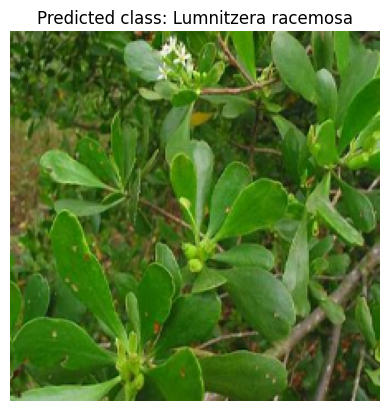

Predicted class probabilities: [[0.02581661 0.04366121 0.8669603  0.03019073 0.0333711 ]]
Predicted class: Lumnitzera racemosa


In [17]:
# Testing the model
img_path = r"E:\\Mangrove project\\EfficientNet\\lrTest.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
resize = tf.image.resize(img, (224, 224))  # Use (224, 224) as the input size
input_image = np.expand_dims(resize, 0) / 255.0  # Normalize and add batch dimension

yhat = model.predict(input_image)
predicted_class_idx = np.argmax(yhat, axis=1)[0]
predicted_class_name = class_names[predicted_class_idx]

plt.imshow(resize.numpy().astype(np.uint8))
plt.title(f'Predicted class: {predicted_class_name}')
plt.axis('off')
plt.show()

print(f'Predicted class probabilities: {yhat}')
print(f'Predicted class: {predicted_class_name}')